# Курсовая работа по теме "Машинное обучение в задачах идентификации личности по изображению"
## Минаков Артём, ПМ19-3


### 1) Import functions and libraries

In [ ]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 16.1 MB/s 


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training, extract_face
import torch
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from google.colab import drive
import glob
from torch.autograd import Variable
from os import listdir
import copy
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.image as mpimg
%matplotlib inline

### 2) Downloading data and setting values for the params

In [ ]:
# Использую датасет, который сам же сформировал
# Датасет содержит фотографии топ 30 самых дорогих футболистов по данным https://www.transfermarkt.world/spieler-statistik/wertvollstespieler/marktwertetop на 01.12.2022 
# В папке football_stars_train вложены 30 папок, в каждой из которых по 5 фотографий футболиста, имя и фамилия которого указаны в названии папки
# В папке football_stars_test такая же структура, но суммарно всего 30 фотографий, по одной на каждого футболиста
# Суммарно 150 фотографий на тренировачный и валидационный наборы, а также 30 для тестового

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_dir = '/content/drive/MyDrive/datasets/football_stars_train'
test_data_dir = '/content/drive/MyDrive/datasets/football_stars_test'

batch_size = 30
epochs = 12
workers = 2

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


### 3) Preprocessing, MTCNN 

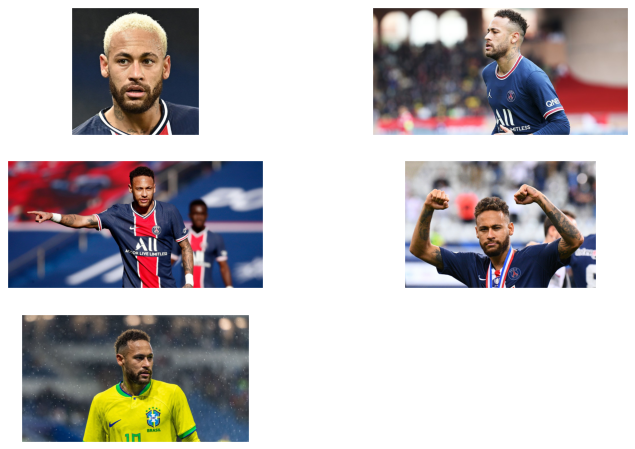

In [ ]:
# Вывод фотографий до обработки
images = []
for img_path in glob.glob('/content/drive/MyDrive/datasets/football_stars_train/Neymar/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(12,8))
columns = 2
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

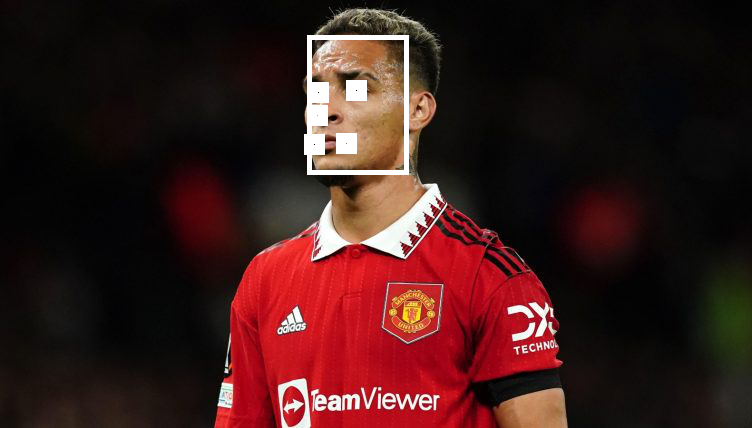

In [ ]:
# Пример использования MTCNN для выделения лиц на фотографиях
mtcnn = MTCNN(keep_all=True)
img = Image.open('/content/drive/MyDrive/datasets/football_stars_test/Antony/antony-manchester-united-2022-752x428.jpg')
boxes, probs, points = mtcnn.detect(img, landmarks=True)
img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)
for i, (box, point) in enumerate(zip(boxes, points)):
  draw.rectangle(box.tolist(), width=5)
  for p in point:
    draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=10)
  extract_face(img, box, save_path='detected_face_{}.jpg'.format(i))
img_draw.save('/content/drive/MyDrive/datasets/output/Antony_detected.jpg')
img_draw

In [ ]:
# Пример использования MTCNN для выделения лиц на фотографиях
mtcnn = MTCNN(keep_all=True)
img = Image.open('/content/drive/MyDrive/datasets/football_stars_train/Mohamed Salah/Mohamed-Salah.jpeg')
boxes, probs, points = mtcnn.detect(img, landmarks=True)
img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)
for i, (box, point) in enumerate(zip(boxes, points)):
  draw.rectangle(box.tolist(), width=5)
  for p in point:
    draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=10)
  extract_face(img, box, save_path='detected_face_{}.jpg'.format(i))
img_draw.save('/content/drive/MyDrive/datasets/output/Salah_detected.jpg')
img_draw

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)


### 4) Define datasets

In [ ]:
dataset = datasets.ImageFolder(train_data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(train_data_dir, train_data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    


Batch 5 of 5

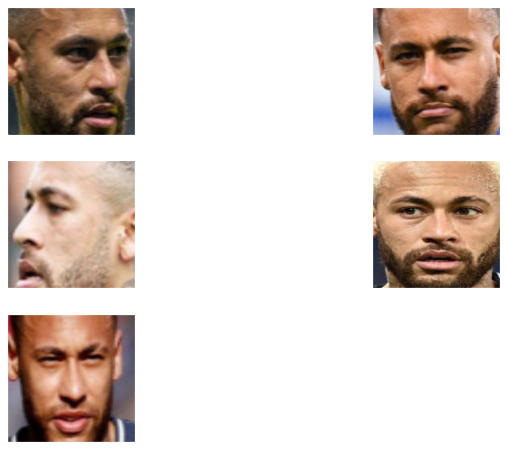

In [ ]:
# Вывод фотографий после обработки
images = []
for img_path in glob.glob('/content/drive/MyDrive/datasets/football_stars_train_cropped/Neymar/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(12,8))
columns = 2
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

In [ ]:
test_dataset = datasets.ImageFolder(test_data_dir, transform=transforms.Resize((512, 512)))
test_dataset.samples = [
  
    (p, p.replace(test_data_dir, test_data_dir + '_cropped'))
        for p, _ in test_dataset.samples
]
        
test_loader = DataLoader(
    test_dataset,
    num_workers=workers,
    batch_size=30,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(test_loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(test_loader)), end='')
# Remove mtcnn to reduce GPU memory usage
del mtcnn

Batch 1 of 1

In [ ]:
dataset.class_to_idx

{'Antony': 0,
 'Aurelien Tchouameni': 1,
 'Bernardo Silva': 2,
 'Bruno Fernandes': 3,
 'Bukayo Saka': 4,
 'Christopher Nkunku': 5,
 'Declan Rice': 6,
 'Dusan Vlahovic': 7,
 'Erling Haaland': 8,
 'Federico Valverde': 9,
 'Gabriel Jesus': 10,
 'Gavi': 11,
 'Harry Kane': 12,
 'Jamal Musiala': 13,
 'Joshua Kimmich': 14,
 'Jude Bellingham': 15,
 'Kevin De Bruyne': 16,
 'Kulian Mbappe': 17,
 'Lautaro Martinez': 18,
 'Luis Diaz': 19,
 'Mason Mount': 20,
 'Mohamed Salah': 21,
 'Neymar': 22,
 'Pedri': 23,
 'Phil Foden': 24,
 'Rafael Leao': 25,
 'Rodri': 26,
 'Rodrygo': 27,
 'Ruben Dias': 28,
 'Vinicius Junior': 29}

### 5) Define model, optimizer, scheduler and dataloader

In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(train_data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
val_inds = np.arange(1,151,5)
train_inds = np.array(list(set(img_inds)^set(val_inds)))

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [ ]:
test_dataset = datasets.ImageFolder(test_data_dir + '_cropped', transform=trans)
test_loader = DataLoader(
    test_dataset,
    num_workers=workers,
    batch_size=30
)

### 6)  Define loss function, train the model, vizualize the process

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'accuracy': training.accuracy
}

In [ ]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []


In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
    
    resnet.train()
    tr_loss, tr_acc = training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer)
    train_loss.append(tr_loss)
    train_acc.append(tr_acc['accuracy'])
    resnet.eval()
    v_loss, v_acc = training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    val_loss.append(v_loss)
    val_acc.append(v_acc['accuracy'])

writer.close()



Initial
----------
Valid |     1/1    | loss:    3.4999 | accuracy:    0.0667   

Epoch 1/12
----------
Train |     4/4    | loss:    2.8202 | accuracy:    0.2500   
Valid |     1/1    | loss:    8.9255 | accuracy:    0.0333   

Epoch 2/12
----------
Train |     4/4    | loss:    1.1264 | accuracy:    0.7750   
Valid |     1/1    | loss:    5.9806 | accuracy:    0.0667   

Epoch 3/12
----------
Train |     4/4    | loss:    0.3820 | accuracy:    0.9667   
Valid |     1/1    | loss:    4.4221 | accuracy:    0.1667   

Epoch 4/12
----------
Train |     4/4    | loss:    0.1881 | accuracy:    0.9750   
Valid |     1/1    | loss:    3.0407 | accuracy:    0.2667   

Epoch 5/12
----------
Train |     4/4    | loss:    0.1142 | accuracy:    0.9917   
Valid |     1/1    | loss:    2.5904 | accuracy:    0.3667   

Epoch 6/12
----------
Train |     4/4    | loss:    0.0699 | accuracy:    1.0000   
Valid |     1/1    | loss:    1.8167 | accuracy:    0.5333   

Epoch 7/12
----------
Train |     

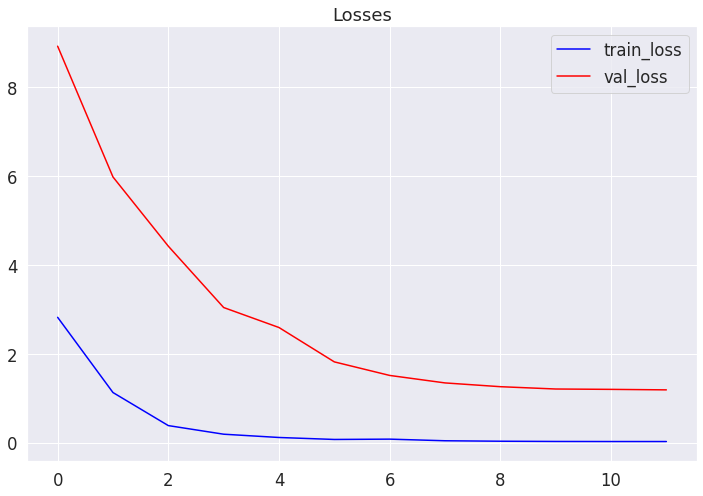

In [ ]:
rcParams['figure.figsize'] = 12, 8 
plt.plot(train_loss, color = 'blue', label = 'train_loss')
plt.plot(val_loss, color = 'red', label = 'val_loss')
plt.title('Losses')
plt.legend()
plt.show()

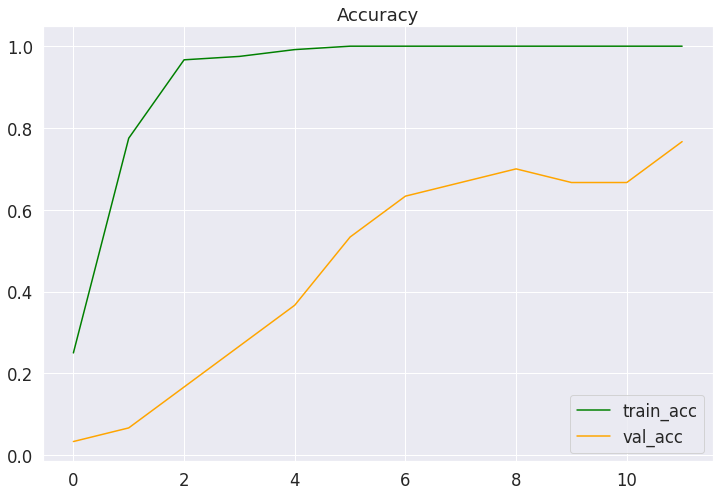

In [ ]:
plt.plot(train_acc, color = 'green', label = 'train_acc')
plt.plot(val_acc, color = 'orange', label = 'val_acc')
plt.title('Accuracy')
plt.legend()
plt.show()

 ### 7) Save the best model and check it on the test data

In [ ]:
torch.save(resnet, '/content/drive/MyDrive/Kursovaya_4/model_final')

In [ ]:
model = torch.load('/content/drive/MyDrive/Kursovaya_4/model_final')

In [ ]:
with torch.no_grad():
    players = list(test_dataset.class_to_idx.keys())
    pred=[]
    correct = 0
    total = 0

    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(total):
          print(f'Real player: {players[labels[i]]}\nPredicted : {players[predicted[i]]} ')
          print('--------------------------')
          if players[labels[i]] == players[predicted[i]]:
            pred.append('correct')
          else:
            pred.append('incorrect')
    print(f'{correct} out of {total} players predicted correctly')
    print(f'Accuracy of the model on the test images: {(100 * correct / total):.2f} %')
    print()

Real player: Antony
Predicted : Antony 
--------------------------
Real player: Aurelien Tchouameni
Predicted : Aurelien Tchouameni 
--------------------------
Real player: Bernardo Silva
Predicted : Bernardo Silva 
--------------------------
Real player: Bruno Fernandes
Predicted : Bruno Fernandes 
--------------------------
Real player: Bukayo Saka
Predicted : Bukayo Saka 
--------------------------
Real player: Christopher Nkunku
Predicted : Christopher Nkunku 
--------------------------
Real player: Declan Rice
Predicted : Declan Rice 
--------------------------
Real player: Dusan Vlahovic
Predicted : Dusan Vlahovic 
--------------------------
Real player: Erling Haaland
Predicted : Erling Haaland 
--------------------------
Real player: Federico Valverde
Predicted : Kevin De Bruyne 
--------------------------
Real player: Gabriel Jesus
Predicted : Gabriel Jesus 
--------------------------
Real player: Gavi
Predicted : Gavi 
--------------------------
Real player: Harry Kane
Predic

In [ ]:
res_table = pd.DataFrame({'Players': players,
              'Prediction':pred})
res_table.to_excel('/content/drive/MyDrive/datasets/kursovaya_4_results.xlsx')
res_table

,Players,Prediction
0,Antony,correct
1,Aurelien Tchouameni,correct
2,Bernardo Silva,correct
3,Bruno Fernandes,correct
4,Bukayo Saka,correct
5,Christopher Nkunku,correct
6,Declan Rice,correct
7,Dusan Vlahovic,correct
8,Erling Haaland,correct
9,Federico Valverde,incorrect


# Результаты 

1.   26 из 30 игроков из тестового набора данных предсказаны верно, следовательно **Accuracy на тесте = 86.67%**
2.   Accuracy на тренировочном наборе данных удалось достичь 100%
3.   Значение функции ошибок на тренировочном наборе данных всео 0.023



